# CSC413 Final Project

Amey Dhamgunde

Initialization, dowloading datasets, etc.

In [1]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

seed = 31
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [2]:
!gdown --id 11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 203MB/s]


In [3]:
max_vocab = 2000
max_len = 200
embedding_size = 60

filename = 'IMDB Dataset.csv'

In [4]:
def process_data(max_vocab, filename, review_len):
    reviews = []
    targets = []
    with open(filename, 'r') as data:
        read_csv = csv.reader(data)
        fl = True
        for row in read_csv:
            if not fl:
                reviews.append(row[0])
                targets.append(int(row[1]=='positive'))
            else:
                fl = False
    
    tk = tf.keras.preprocessing.text.Tokenizer(num_words=max_vocab)
    tk.fit_on_texts(reviews)
    reviews_to_seq = tk.texts_to_sequences(reviews)
    reviews_padded = tf.keras.preprocessing.sequence.pad_sequences(reviews_to_seq, maxlen=max_len)
    train_ratio = 0.8
    reviews_train, reviews_remainder, targets_train, targets_remainder = train_test_split(reviews_padded, targets, train_size=train_ratio)
    reviews_valid, reviews_test, targets_valid, targets_test = train_test_split(reviews_remainder, targets_remainder, train_size=0.5)
    return torch.IntTensor(reviews_train), torch.LongTensor(targets_train), torch.IntTensor(reviews_valid), torch.LongTensor(targets_valid), torch.IntTensor(reviews_test), torch.LongTensor(targets_test)

In [5]:
reviews_train, targets_train, reviews_valid, targets_valid, reviews_test, targets_test = process_data(max_vocab, filename, max_len)

In [6]:
import matplotlib.pyplot as plt

def plot_losses(train_loss, train_acc, val_loss, val_acc):
    #Plot training loss
    plt.title("Train vs Validation Loss")
    plt.plot(train_loss, label="Train")
    plt.plot(val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.show()

# CNN

In [47]:
class CNN(nn.Module):
    def __init__(self, max_vocab, embedding_size, max_len, n_hidden, n_classes, bias):
        super().__init__()

        self.embed = nn.Embedding(num_embeddings=max_vocab, embedding_dim=embedding_size)
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=embedding_size, out_channels=n_hidden*2, kernel_size=3, padding='same'), 
                                   nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv1d(in_channels=2*n_hidden, out_channels=n_hidden, kernel_size=3, padding='same'),
                                   nn.ReLU())
        self.global_max_pool = nn.AdaptiveMaxPool1d(output_size=1)
        self.linear = nn.Linear(in_features=n_hidden, out_features=2, bias=bias)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input):
        x = self.embed(input)
        x = torch.transpose(x, 2, 1)

        x = self.conv1(x)

        x = self.conv2(x)

        x = self.global_max_pool(x)
        x = torch.squeeze(x)

        out = torch.squeeze(self.linear(self.dropout(x)))
        return out

        return F.log_softmax(out, dim=-1)

In [48]:
args_cnn = {"epochs": 50,
        "lr": 0.0005,
        "weight_decay": 5e-4,
        "bias": True, 
        "n_hidden": 64
        }


In [49]:
model = CNN(max_vocab=max_vocab,
            embedding_size=embedding_size,
            max_len=max_len,
            n_hidden=args_cnn["n_hidden"],
            n_classes=2,
            bias=args_cnn["bias"])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args_cnn["lr"], weight_decay=args_cnn["weight_decay"])

def accuracy(output, labels):
    preds = torch.argmax(output, dim=1)
    batch_correct = (preds==labels).sum().item()
    return batch_correct

batch_size=250
PATH='CNN_model.pt'

def train(epochs):
    min_loss = 10
    max_acc = 0
    state = {}
    train_acc_epoch = []
    val_acc_epoch = []
    train_loss_epoch= []
    val_loss_epoch = []

    for epoch in range(0, epochs):
        t = time.time()
        model.train()
        acc_train_c = 0
        loss_train_c = 0
        train_indices = torch.randperm(len(targets_train))

        for it in range(0, len(targets_train), batch_size):
            batch = train_indices[it:it+batch_size]
            optimizer.zero_grad()
            out = model(reviews_train[batch])
            loss_train = criterion(out, targets_train[batch])
            loss_train_c += loss_train.item()*batch_size
            acc_train = accuracy(out, targets_train[batch])
            acc_train_c += acc_train
            loss_train.backward()
            optimizer.step()
        loss_train_c /= len(targets_train)
        acc_train_c /= len(targets_train)
        train_loss_epoch.append(loss_train_c)
        train_acc_epoch.append(acc_train_c)

        model.eval()
        out = model(reviews_valid)
        loss_val = criterion(out, targets_valid)
        acc_val = accuracy(out, targets_valid)/len(targets_valid)

        val_loss_epoch.append(loss_val.item())
        val_acc_epoch.append(acc_val)

        if loss_val.item() < min_loss:
            min_loss = loss_val.item()
            max_acc = acc_val
            state = {'epoch': epoch+1, 'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(), 'loss': min_loss}
            

        print('Epoch: {:04d}'.format(epoch+1),
            'loss_train: {:.4f}'.format(loss_train_c),
            'acc_train: {:.4f}'.format(acc_train_c),
            'loss_val: {:.4f}'.format(loss_val.item()),
            'acc_val: {:.4f}'.format(acc_val),
            'time: {:.4f}s'.format(time.time() - t))
    
    torch.save(state, PATH)
    plot_losses(train_loss_epoch, train_acc_epoch, val_loss_epoch, val_acc_epoch)
    

def test():
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("From epoch: ", checkpoint['epoch'], " with val loss ", checkpoint['loss'])

    model.eval()
    output = model(reviews_test)
    loss_test = criterion(output, targets_test)
    acc_test = accuracy(output, targets_test)/len(targets_test)
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))
    
model = model.to(device)
reviews_train, targets_train, reviews_valid, targets_valid, reviews_test, targets_test = \
reviews_train.to(device), targets_train.to(device), reviews_valid.to(device), targets_valid.to(device), reviews_test.to(device), targets_test.to(device)

In [50]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.size())

embed.weight torch.Size([2000, 60])
conv1.0.weight torch.Size([128, 60, 3])
conv1.0.bias torch.Size([128])
conv2.0.weight torch.Size([64, 128, 3])
conv2.0.bias torch.Size([64])
linear.weight torch.Size([2, 64])
linear.bias torch.Size([2])


Epoch: 0001 loss_train: 0.6450 acc_train: 0.6187 loss_val: 0.5522 acc_val: 0.7378 time: 1.5643s
Epoch: 0002 loss_train: 0.5174 acc_train: 0.7482 loss_val: 0.4640 acc_val: 0.7834 time: 1.4903s
Epoch: 0003 loss_train: 0.4558 acc_train: 0.7875 loss_val: 0.4255 acc_val: 0.8074 time: 2.2257s
Epoch: 0004 loss_train: 0.4175 acc_train: 0.8126 loss_val: 0.3928 acc_val: 0.8246 time: 1.4777s
Epoch: 0005 loss_train: 0.3793 acc_train: 0.8324 loss_val: 0.3714 acc_val: 0.8320 time: 1.4799s
Epoch: 0006 loss_train: 0.3549 acc_train: 0.8447 loss_val: 0.3481 acc_val: 0.8410 time: 1.4753s
Epoch: 0007 loss_train: 0.3271 acc_train: 0.8608 loss_val: 0.3339 acc_val: 0.8514 time: 1.4798s
Epoch: 0008 loss_train: 0.3113 acc_train: 0.8677 loss_val: 0.3299 acc_val: 0.8512 time: 1.4802s
Epoch: 0009 loss_train: 0.2969 acc_train: 0.8762 loss_val: 0.3239 acc_val: 0.8548 time: 1.4965s
Epoch: 0010 loss_train: 0.2860 acc_train: 0.8803 loss_val: 0.3180 acc_val: 0.8612 time: 1.5116s
Epoch: 0011 loss_train: 0.2765 acc_train

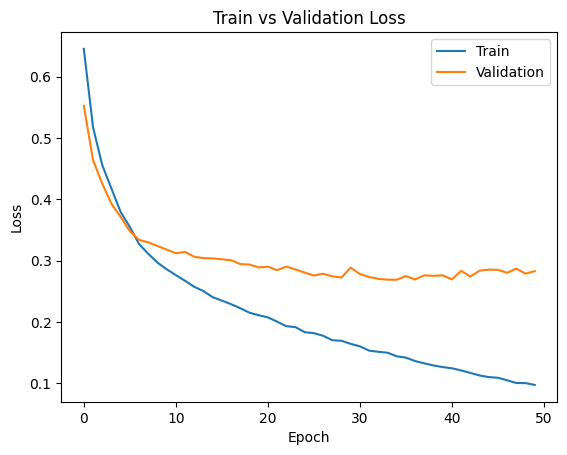

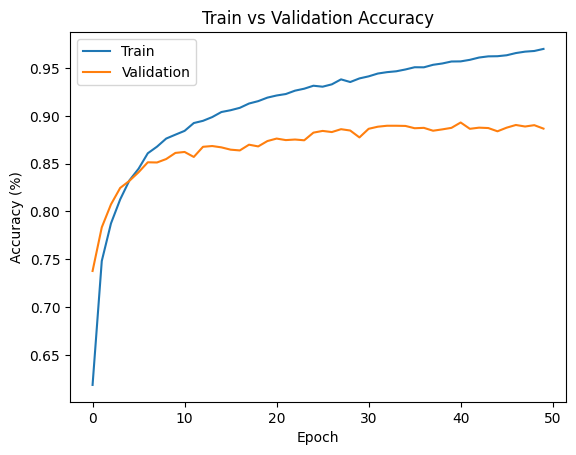

Optimization Finished!
Total time elapsed: 76.7684s
From epoch:  35  with val loss  0.2689340114593506
Test set results: loss= 0.2846 accuracy= 0.8904


In [51]:
# Train model
t_total = time.time()
train(args_cnn["epochs"])
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Evaluate
test()

# RNN

In [92]:
class RNN(nn.Module):
    def __init__(self, max_vocab, embedding_size, max_len, n_hidden, n_classes, bias):
        super().__init__()

        self.max_len = max_len

        self.embed = nn.Embedding(num_embeddings=max_vocab, embedding_dim=embedding_size)
        self.rnn_1 = nn.GRU(input_size=embedding_size, hidden_size=n_hidden, num_layers=1, batch_first=True)
        self.linear = nn.Linear(in_features=n_hidden, out_features=2, bias=bias)
        self.global_max_pool = nn.AdaptiveMaxPool1d(output_size=1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input):
        x = self.embed(input)

        x = self.rnn_1(x)[0]
        x = torch.squeeze(self.global_max_pool(torch.transpose(x, 1, 2)))
        #x = torch.squeeze(torch.transpose(x, 1, 2)[:, :, self.max_len-1])

        out = self.linear(self.dropout(x))
        return out

        return F.log_softmax(out, dim=-1)

In [93]:
args_rnn = {"epochs": 50,
        "lr": 0.0005,
        "weight_decay": 5e-4,
        "bias": True, 
        "n_hidden": 64
        }


In [94]:
model = RNN(max_vocab=max_vocab,
            embedding_size=embedding_size,
            max_len=max_len,
            n_hidden=args_rnn["n_hidden"],
            n_classes=2,
            bias=args_rnn["bias"])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args_rnn["lr"], weight_decay=args_rnn["weight_decay"])

def accuracy(output, labels):
    preds = torch.argmax(output, dim=1)
    batch_correct = (preds==labels).sum().item()
    return batch_correct

batch_size=250
PATH='RNN_model.pt'

def train(epochs):
    min_loss = 10
    max_acc = 0
    state = {}
    train_acc_epoch = []
    val_acc_epoch = []
    train_loss_epoch= []
    val_loss_epoch = []

    for epoch in range(0, epochs):
        t = time.time()
        model.train()
        acc_train_c = 0
        loss_train_c = 0
        train_indices = torch.randperm(len(targets_train))

        for it in range(0, len(targets_train), batch_size):
            batch = train_indices[it:it+batch_size]
            optimizer.zero_grad()
            out = model(reviews_train[batch])
            loss_train = criterion(out, targets_train[batch])
            loss_train_c += loss_train.item()*batch_size
            acc_train = accuracy(out, targets_train[batch])
            acc_train_c += acc_train
            loss_train.backward()
            optimizer.step()
        loss_train_c /= len(targets_train)
        acc_train_c /= len(targets_train)
        train_loss_epoch.append(loss_train_c)
        train_acc_epoch.append(acc_train_c)

        model.eval()
        out = model(reviews_valid)
        loss_val = criterion(out, targets_valid)
        acc_val = accuracy(out, targets_valid)/len(targets_valid)

        val_loss_epoch.append(loss_val.item())
        val_acc_epoch.append(acc_val)

        if loss_val.item() < min_loss:
            min_loss = loss_val.item()
            max_acc = acc_val
            state = {'epoch': epoch+1, 'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(), 'loss': min_loss}
            

        print('Epoch: {:04d}'.format(epoch+1),
            'loss_train: {:.4f}'.format(loss_train_c),
            'acc_train: {:.4f}'.format(acc_train_c),
            'loss_val: {:.4f}'.format(loss_val.item()),
            'acc_val: {:.4f}'.format(acc_val),
            'time: {:.4f}s'.format(time.time() - t))
    
    torch.save(state, PATH)
    plot_losses(train_loss_epoch, train_acc_epoch, val_loss_epoch, val_acc_epoch)
    

def test():
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("From epoch: ", checkpoint['epoch'], " with val loss ", checkpoint['loss'])

    model.eval()
    output = model(reviews_test)
    loss_test = criterion(output, targets_test)
    acc_test = accuracy(output, targets_test)/len(targets_test)
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))

model = model.to(device)
reviews_train, targets_train, reviews_valid, targets_valid, reviews_test, targets_test = \
reviews_train.to(device), targets_train.to(device), reviews_valid.to(device), targets_valid.to(device), reviews_test.to(device), targets_test.to(device)

In [95]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.size())

embed.weight torch.Size([2000, 60])
rnn_1.weight_ih_l0 torch.Size([192, 60])
rnn_1.weight_hh_l0 torch.Size([192, 64])
rnn_1.bias_ih_l0 torch.Size([192])
rnn_1.bias_hh_l0 torch.Size([192])
linear.weight torch.Size([2, 64])
linear.bias torch.Size([2])


Epoch: 0001 loss_train: 0.6874 acc_train: 0.5441 loss_val: 0.6511 acc_val: 0.7058 time: 1.2553s
Epoch: 0002 loss_train: 0.5972 acc_train: 0.6876 loss_val: 0.5286 acc_val: 0.7534 time: 1.1685s
Epoch: 0003 loss_train: 0.5033 acc_train: 0.7572 loss_val: 0.4793 acc_val: 0.7644 time: 1.1777s
Epoch: 0004 loss_train: 0.4519 acc_train: 0.7884 loss_val: 0.4156 acc_val: 0.8204 time: 1.1772s
Epoch: 0005 loss_train: 0.4168 acc_train: 0.8106 loss_val: 0.3854 acc_val: 0.8332 time: 1.1760s
Epoch: 0006 loss_train: 0.3959 acc_train: 0.8234 loss_val: 0.3856 acc_val: 0.8280 time: 1.1726s
Epoch: 0007 loss_train: 0.3812 acc_train: 0.8301 loss_val: 0.3587 acc_val: 0.8420 time: 1.1943s
Epoch: 0008 loss_train: 0.3679 acc_train: 0.8382 loss_val: 0.3494 acc_val: 0.8438 time: 1.2624s
Epoch: 0009 loss_train: 0.3561 acc_train: 0.8439 loss_val: 0.3441 acc_val: 0.8488 time: 1.2202s
Epoch: 0010 loss_train: 0.3443 acc_train: 0.8497 loss_val: 0.3645 acc_val: 0.8310 time: 1.1786s
Epoch: 0011 loss_train: 0.3380 acc_train

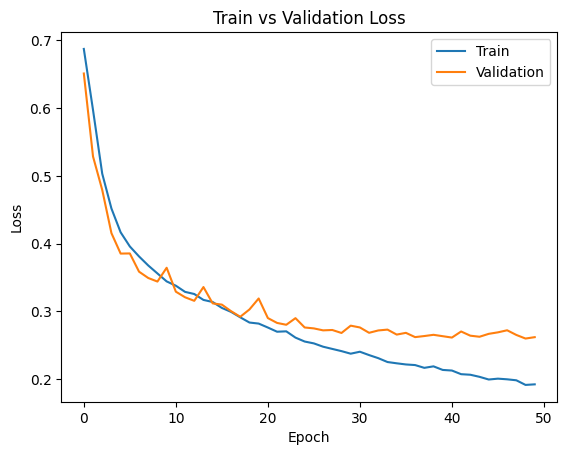

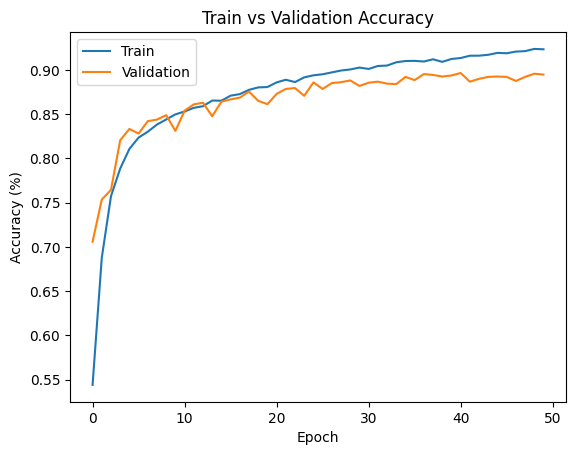

Optimization Finished!
Total time elapsed: 61.0522s
From epoch:  49  with val loss  0.2600327730178833
Test set results: loss= 0.2740 accuracy= 0.8862


In [96]:
# Train model
t_total = time.time()
train(args_rnn["epochs"])
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Evaluate
test()

# CNN + RNN

In [198]:
class CNN_RNN(nn.Module):
    def __init__(self, max_vocab, embedding_size, max_len, n_hidden, n_classes, bias):
        super().__init__()

        self.max_len = max_len
        self.n_hidden = n_hidden

        self.embed = nn.Embedding(num_embeddings=max_vocab, embedding_dim=embedding_size)
        self.rnn_1 = nn.RNN(input_size=embedding_size, hidden_size=n_hidden, num_layers=1, batch_first=True)
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=n_hidden, out_channels=n_hidden, kernel_size=3, padding='same'), 
                                   nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv1d(in_channels=2*n_hidden, out_channels=n_hidden, kernel_size=3, padding='same'),
                                   nn.GELU())
        self.global_max_pool = nn.AdaptiveMaxPool1d(output_size=1)
        self.linear = nn.Linear(in_features=n_hidden, out_features=2, bias=bias)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input):
        x = self.embed(input)

        x = self.rnn_1(x)[0]
        x = torch.transpose(x, 2, 1)
        x = self.conv1(x)
        #x = self.conv2(x)
        x = torch.squeeze(self.global_max_pool(x))

        out = self.linear(self.dropout(x))
        return out

        return F.log_softmax(out, dim=-1)

In [199]:
args_cnn_rnn = {"epochs": 50,
        "lr": 0.0005,
        "weight_decay": 5e-4,
        "bias": True, 
        "n_hidden": 64
        }


In [200]:
model = CNN_RNN(max_vocab=max_vocab,
            embedding_size=embedding_size,
            max_len=max_len,
            n_hidden=args_cnn_rnn["n_hidden"],
            n_classes=2,
            bias=args_cnn_rnn["bias"])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args_cnn_rnn["lr"], weight_decay=args_cnn_rnn["weight_decay"])

def accuracy(output, labels):
    preds = torch.argmax(output, dim=1)
    batch_correct = (preds==labels).sum().item()
    return batch_correct


batch_size=250
PATH='CNN_RNN_model.pt'

def train(epochs):
    min_loss = 10
    max_acc = 0
    state = {}
    train_acc_epoch = []
    val_acc_epoch = []
    train_loss_epoch= []
    val_loss_epoch = []

    for epoch in range(0, epochs):
        t = time.time()
        model.train()
        acc_train_c = 0
        loss_train_c = 0
        train_indices = torch.randperm(len(targets_train))

        for it in range(0, len(targets_train), batch_size):
            batch = train_indices[it:it+batch_size]
            optimizer.zero_grad()
            out = model(reviews_train[batch])
            loss_train = criterion(out, targets_train[batch])
            loss_train_c += loss_train.item()*batch_size
            acc_train = accuracy(out, targets_train[batch])
            acc_train_c += acc_train
            loss_train.backward()
            optimizer.step()
        loss_train_c /= len(targets_train)
        acc_train_c /= len(targets_train)
        train_loss_epoch.append(loss_train_c)
        train_acc_epoch.append(acc_train_c)

        model.eval()
        out = model(reviews_valid)
        loss_val = criterion(out, targets_valid)
        acc_val = accuracy(out, targets_valid)/len(targets_valid)

        val_loss_epoch.append(loss_val.item())
        val_acc_epoch.append(acc_val)

        if loss_val.item() < min_loss:
            min_loss = loss_val.item()
            max_acc = acc_val
            state = {'epoch': epoch+1, 'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(), 'loss': min_loss}
            

        print('Epoch: {:04d}'.format(epoch+1),
            'loss_train: {:.4f}'.format(loss_train_c),
            'acc_train: {:.4f}'.format(acc_train_c),
            'loss_val: {:.4f}'.format(loss_val.item()),
            'acc_val: {:.4f}'.format(acc_val),
            'time: {:.4f}s'.format(time.time() - t))
    
    torch.save(state, PATH)
    plot_losses(train_loss_epoch, train_acc_epoch, val_loss_epoch, val_acc_epoch)
    

def test():
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("From epoch: ", checkpoint['epoch'], " with val loss ", checkpoint['loss'])

    model.eval()
    output = model(reviews_test)
    loss_test = criterion(output, targets_test)
    acc_test = accuracy(output, targets_test)/len(targets_test)
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))
    
model = model.to(device)
reviews_train, targets_train, reviews_valid, targets_valid, reviews_test, targets_test = \
reviews_train.to(device), targets_train.to(device), reviews_valid.to(device), targets_valid.to(device), reviews_test.to(device), targets_test.to(device)

In [201]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.size())

embed.weight torch.Size([2000, 60])
rnn_1.weight_ih_l0 torch.Size([64, 60])
rnn_1.weight_hh_l0 torch.Size([64, 64])
rnn_1.bias_ih_l0 torch.Size([64])
rnn_1.bias_hh_l0 torch.Size([64])
conv1.0.weight torch.Size([64, 64, 3])
conv1.0.bias torch.Size([64])
conv2.0.weight torch.Size([64, 128, 3])
conv2.0.bias torch.Size([64])
linear.weight torch.Size([2, 64])
linear.bias torch.Size([2])


Epoch: 0001 loss_train: 0.6728 acc_train: 0.5792 loss_val: 0.6187 acc_val: 0.6894 time: 1.1028s
Epoch: 0002 loss_train: 0.5753 acc_train: 0.7016 loss_val: 0.5148 acc_val: 0.7546 time: 1.0683s
Epoch: 0003 loss_train: 0.4995 acc_train: 0.7555 loss_val: 0.4644 acc_val: 0.7828 time: 1.0430s
Epoch: 0004 loss_train: 0.4550 acc_train: 0.7861 loss_val: 0.4271 acc_val: 0.8028 time: 0.9963s
Epoch: 0005 loss_train: 0.4249 acc_train: 0.8035 loss_val: 0.4105 acc_val: 0.8064 time: 0.9865s
Epoch: 0006 loss_train: 0.3996 acc_train: 0.8202 loss_val: 0.3810 acc_val: 0.8304 time: 0.9895s
Epoch: 0007 loss_train: 0.3780 acc_train: 0.8323 loss_val: 0.3741 acc_val: 0.8284 time: 0.9898s
Epoch: 0008 loss_train: 0.3634 acc_train: 0.8397 loss_val: 0.3578 acc_val: 0.8366 time: 0.9933s
Epoch: 0009 loss_train: 0.3515 acc_train: 0.8441 loss_val: 0.3477 acc_val: 0.8444 time: 0.9912s
Epoch: 0010 loss_train: 0.3407 acc_train: 0.8522 loss_val: 0.3390 acc_val: 0.8466 time: 0.9992s
Epoch: 0011 loss_train: 0.3318 acc_train

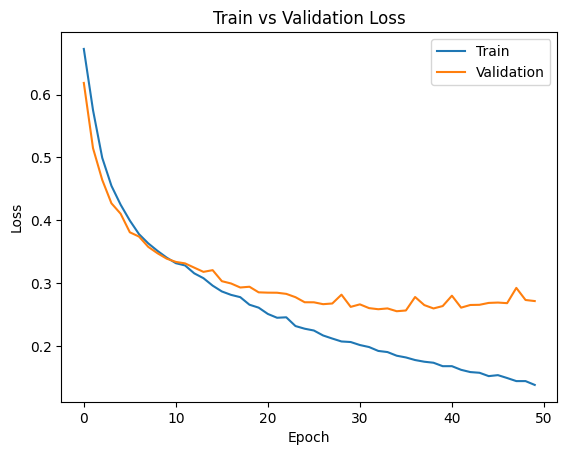

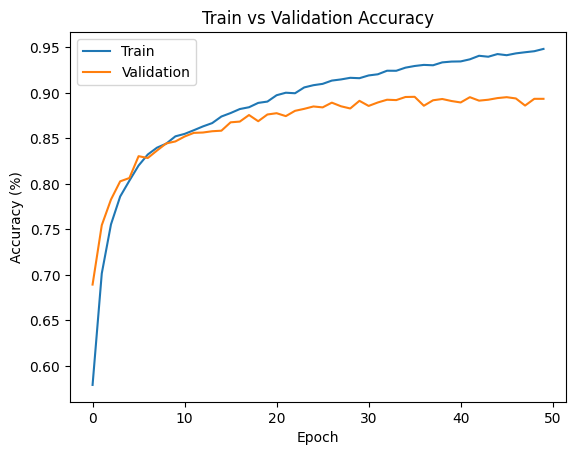

Optimization Finished!
Total time elapsed: 51.4050s
From epoch:  35  with val loss  0.2553500235080719
Test set results: loss= 0.2644 accuracy= 0.8962


In [202]:
# Train model
t_total = time.time()
train(args_cnn_rnn["epochs"])
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Evaluate
test()

# Transformer

In [7]:
class transformer(nn.Module):
    def __init__(self, max_vocab, embedding_size, max_len, n_hidden, n_classes, bias):
        super().__init__()

        self.max_len = max_len
        self.embedding_size = embedding_size
        self.n_hidden = n_hidden

        self.embed = nn.Embedding(num_embeddings=max_vocab, embedding_dim=embedding_size)
        enc_layer = nn.TransformerEncoderLayer(d_model=embedding_size, nhead=6, dim_feedforward=n_hidden, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=6)

        self.act_fun = nn.ReLU()

        self.global_max_pool = nn.AdaptiveMaxPool1d(output_size=1)
        self.fc = nn.Linear(embedding_size, embedding_size)
        self.decoder = nn.Linear(in_features=embedding_size, out_features=2, bias=bias)

    def forward(self, input):
        x = self.embed(input)

        x = self.encoder(src=x)

        x = torch.transpose(x, 1, 2)

        pooled = self.act_fun(self.fc(torch.squeeze(self.global_max_pool(x), dim=2)))


        

        #x = torch.transpose(x, 1, 2)
        
        #x = torch.squeeze(self.global_max_pool(x), dim=2)

        out = self.decoder(pooled)
        return out

        return F.log_softmax(out, dim=-1)

In [8]:
args_transformer = {"epochs": 50,
        "lr": 0.0001,
        "weight_decay": 5e-4,
        "bias": True, 
        "n_hidden": 256
        }


In [11]:
model = transformer(max_vocab=max_vocab,
            embedding_size=embedding_size,
            max_len=max_len,
            n_hidden=args_transformer["n_hidden"],
            n_classes=2,
            bias=args_transformer["bias"])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args_transformer["lr"])

def accuracy(output, labels):
    preds = torch.argmax(output, dim=1)
    batch_correct = (preds==labels).sum().item()
    return batch_correct

batch_size=125

PATH='Transformer_model.pt'

def train(epochs):
    min_loss = 10
    max_acc = 0
    state = {}
    train_acc_epoch = []
    val_acc_epoch = []
    train_loss_epoch= []
    val_loss_epoch = []

    for epoch in range(0, epochs):
        t = time.time()
        model.train()
        acc_train_c = 0
        loss_train_c = 0
        train_indices = torch.randperm(len(targets_train))

        for it in range(0, len(targets_train), batch_size):
            batch = train_indices[it:it+batch_size]
            optimizer.zero_grad()
            out = model(reviews_train[batch])
            loss_train = criterion(out, targets_train[batch])
            loss_train_c += loss_train.item()*batch_size
            acc_train = accuracy(out, targets_train[batch])
            acc_train_c += acc_train
            loss_train.backward()
            optimizer.step()
        loss_train_c /= len(targets_train)
        acc_train_c /= len(targets_train)
        train_loss_epoch.append(loss_train_c)
        train_acc_epoch.append(acc_train_c)

        model.eval()
        acc_val = 0
        acc_val_c = 0
        loss_val = 0
        loss_val_c = 0
        for it in range(0, len(targets_valid), batch_size):
            out = model(reviews_valid[it:it+batch_size, :])
            loss_val = criterion(out, targets_valid[it:it+batch_size])
            loss_val_c += loss_val.item()*batch_size
            acc_val = accuracy(out, targets_valid[it:it+batch_size])
            acc_val_c += acc_val
        loss_val_c /= len(targets_valid)
        acc_val_c /= len(targets_valid)

        val_loss_epoch.append(loss_val_c)
        val_acc_epoch.append(acc_val_c)

        if loss_val_c < min_loss:
            min_loss = loss_val_c
            max_acc = acc_val_c
            state = {'epoch': epoch+1, 'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(), 'loss': min_loss}
            

        print('Epoch: {:04d}'.format(epoch+1),
            'loss_train: {:.4f}'.format(loss_train_c),
            'acc_train: {:.4f}'.format(acc_train_c),
            'loss_val: {:.4f}'.format(loss_val_c),
            'acc_val: {:.4f}'.format(acc_val_c),
            'time: {:.4f}s'.format(time.time() - t))
    
    torch.save(state, PATH)
    plot_losses(train_loss_epoch, train_acc_epoch, val_loss_epoch, val_acc_epoch)
    

def test():
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("From epoch: ", checkpoint['epoch'], " with val loss ", checkpoint['loss'])

    model.eval()
    loss_test_c = 0
    acc_test_c = 0


    for it in range(0, len(targets_test), batch_size):
        out = model(reviews_test[it:it+batch_size, :])
        loss_test = criterion(out, targets_test[it:it+batch_size])
        loss_test_c += loss_test.item()*batch_size
        acc_test = accuracy(out, targets_test[it:it+batch_size])
        acc_test_c += acc_test
    loss_test_c /= len(targets_test)
    acc_test_c /= len(targets_test)

    print("Test set results:",
          "loss= {:.4f}".format(loss_test_c),
          "accuracy= {:.4f}".format(acc_test_c))

    
model = model.to(device)
reviews_train, targets_train, reviews_valid, targets_valid, reviews_test, targets_test = \
reviews_train.to(device), targets_train.to(device), reviews_valid.to(device), targets_valid.to(device), reviews_test.to(device), targets_test.to(device)

In [20]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.size())

embed.weight torch.Size([2000, 60])
encoder.layers.0.self_attn.in_proj_weight torch.Size([180, 60])
encoder.layers.0.self_attn.in_proj_bias torch.Size([180])
encoder.layers.0.self_attn.out_proj.weight torch.Size([60, 60])
encoder.layers.0.self_attn.out_proj.bias torch.Size([60])
encoder.layers.0.linear1.weight torch.Size([256, 60])
encoder.layers.0.linear1.bias torch.Size([256])
encoder.layers.0.linear2.weight torch.Size([60, 256])
encoder.layers.0.linear2.bias torch.Size([60])
encoder.layers.0.norm1.weight torch.Size([60])
encoder.layers.0.norm1.bias torch.Size([60])
encoder.layers.0.norm2.weight torch.Size([60])
encoder.layers.0.norm2.bias torch.Size([60])
encoder.layers.1.self_attn.in_proj_weight torch.Size([180, 60])
encoder.layers.1.self_attn.in_proj_bias torch.Size([180])
encoder.layers.1.self_attn.out_proj.weight torch.Size([60, 60])
encoder.layers.1.self_attn.out_proj.bias torch.Size([60])
encoder.layers.1.linear1.weight torch.Size([256, 60])
encoder.layers.1.linear1.bias torch

Epoch: 0001 loss_train: 0.6167 acc_train: 0.6588 loss_val: 0.5187 acc_val: 0.7458 time: 39.2916s
Epoch: 0002 loss_train: 0.4806 acc_train: 0.7705 loss_val: 0.4376 acc_val: 0.7984 time: 39.2345s
Epoch: 0003 loss_train: 0.4247 acc_train: 0.8046 loss_val: 0.3949 acc_val: 0.8232 time: 39.0506s
Epoch: 0004 loss_train: 0.3932 acc_train: 0.8246 loss_val: 0.3707 acc_val: 0.8356 time: 39.0380s
Epoch: 0005 loss_train: 0.3675 acc_train: 0.8377 loss_val: 0.3549 acc_val: 0.8386 time: 39.0054s
Epoch: 0006 loss_train: 0.3538 acc_train: 0.8438 loss_val: 0.3449 acc_val: 0.8426 time: 38.9696s
Epoch: 0007 loss_train: 0.3404 acc_train: 0.8512 loss_val: 0.3326 acc_val: 0.8520 time: 38.9761s
Epoch: 0008 loss_train: 0.3288 acc_train: 0.8583 loss_val: 0.3243 acc_val: 0.8602 time: 38.9781s
Epoch: 0009 loss_train: 0.3210 acc_train: 0.8607 loss_val: 0.3242 acc_val: 0.8582 time: 39.0011s
Epoch: 0010 loss_train: 0.3122 acc_train: 0.8677 loss_val: 0.3158 acc_val: 0.8608 time: 38.9858s
Epoch: 0011 loss_train: 0.3056

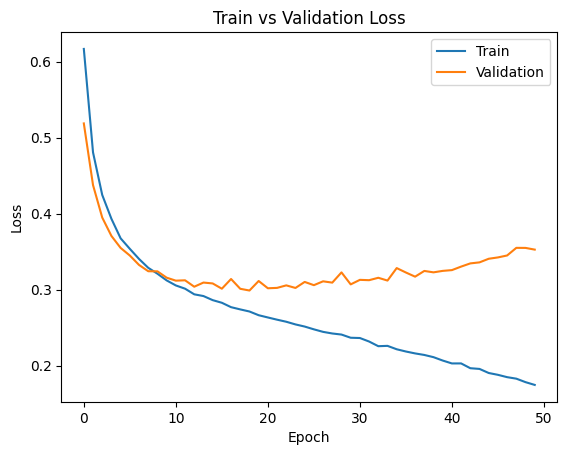

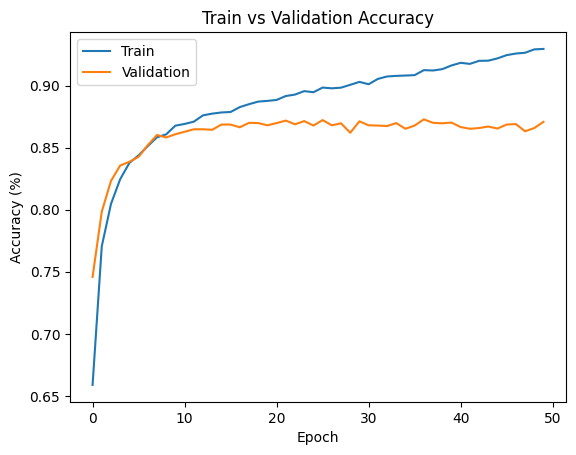

Optimization Finished!
Total time elapsed: 1952.5625s
From epoch:  19  with val loss  0.29892965517938136


OutOfMemoryError: ignored

In [21]:
# Train model
t_total = time.time()

train(args_transformer["epochs"])
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))


In [12]:
# Evaluate
test()

From epoch:  19  with val loss  0.29892965517938136
Test set results: loss= 0.3545 accuracy= 0.8638
